# Q2: Cycle Generative Adversarial Network (CycleGAN)

In [1]:
# Load the necessary imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from library import datasets, models
from library.visualizations.point_pairs import visualize_point_correspondence
from flax import linen as nn
from jax import random, numpy as jnp
import optax
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pio.renderers.default = 'notebook_connected'

/home/trent/anaconda3/envs/python3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In the previous notebook, you saw how GAN tries to learn to generate samples from a desired distribution. In this notebook, you will use CycleGAN to learn how to map samples from one distribution to another. One of the key advantages of CycleGAN is that it does not require a paired dataset. Instead, it learns the sample-to-sample correspondence between two datasets by enforcing cycle consistency. In this homework, you will consider the mapping between two distributions of the blob dataset you saw in the GAN notebook. These are illustrated below.

In [2]:
key = random.PRNGKey(5)
key_A, key_B = random.split(key)

# Create dataset
A = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_A)
B = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_B)

real_A = A.get_tensors()
real_B = B.get_tensors()

In [3]:
fig = make_subplots(rows=1, cols=2, subplot_titles=["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"), name='Real B'), row=1, col=2)
fig.update_layout(title_text="Real samples")
fig.show()

## Part (A): Initialize CycleGAN and interpret generated fake samples

Since you already learned how to create the discriminator and generator in the GAN notebook, you can reuse their architectures below. Remember that we have two different distributions now instead of one for GAN.

In [4]:
# Define ambient dimension, discriminator and generator
AMBIENT_DIM = 2

discriminator_A = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

discriminator_B = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

generator_AB = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])

generator_BA = nn.Sequential([ # TODO: Copy from GAN notebook
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])


In [5]:
# Initialize model with generators, discriminators and loss function.
modules = {
        'generator_AB': generator_AB,
        'generator_BA': generator_BA,
        'discriminator_A': discriminator_A,
        'discriminator_B': discriminator_B,
    }

model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [6]:
# Get generators from untrained model and draw samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

In [7]:
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from untrained generators")
fig.show()

**Q. Are the generated fake samples as you expected? Why or why not?**

A.

## Part (B): Implement cycle consistency loss and train CycleGAN

For the CycleGAN model, we aim to solve the minimax game between the generators and the discriminators:
$$\underset{G_{AB}, G_{BA}}{min}\: \underset{D_A, D_B}{max}\: V(G_{AB}, G_{BA}, D_A, D_B) = \mathcal{L}(G_{AB},G_{BA},D_A, D_B)$$

The full objective is defined as:
$$\mathcal{L}(G_{AB},G_{BA},D_A, D_B) = \mathcal{L}(G_{AB},D_B,A,B) + \mathcal{L}(G_{BA},D_A,B,A) +\lambda \mathcal{L}_{cyc}(G_{AB}, G_{BA})$$
where $\lambda$ controls the relative importance of the two objectives (i.e. GAN or cycle consistency loss) and where the GAN and cycle consistency losses are defined as:
\begin{align*}
\mathcal{L}_{GAN}(G_{AB}, D_B, A, B) &= \mathbb{E}_{b \sim p_{data}(b)}\left[log \: D_B(b)\right]+\mathbb{E}_{a \sim p_{data}(a)}\left[log(1-D_B(G_{AB}(a)))\right] \\
\mathcal{L}_{cyc}(G_{AB}, G_{BA}) &= \mathbb{E}_{a \sim p_{data}(a)}\left[||G_{BA}(G_{AB}(a))-a||_1\right] + \mathbb{E}_{b \sim p_{data}(b)}\left[||G_{AB}(G_{BA}(b))-b||_1\right]
\end{align*}
Note that $\mathcal{L}(G_{BA},D_A,B,A)$ is calculated in similar fashion as $\mathcal{L}(G_{AB},D_B,A,B)$.


In this part, you should implement the GAN and cycle consistency loss functions from above in the train method in `cyclegan.py`. Once you have successfully implemented the functions, you can train the CycleGAN model below.

In [8]:
# Train CycleGAN
lambda_ = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=1000, cycle_loss_weight=lambda_)

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7239; Generator AB Cycle loss:  0.8255; Generator BA Cycle loss:  0.7572; Discriminator A loss:  0.6781; Discriminator B loss:  0.7197: : 1it [00:06,  6.74s/it]
Epoch 1; Generator AB GAN loss:  0.6938; Generator BA GAN loss:  0.7383; Generator AB Cycle loss:  0.8226; Generator BA Cycle loss:  0.7075; Discriminator A loss:  0.6693; Discriminator B loss:  0.7117: : 1it [00:00,  4.81it/s]
Epoch 2; Generator AB GAN loss:  0.6899; Generator BA GAN loss:  0.7550; Generator AB Cycle loss:  0.8195; Generator BA Cycle loss:  0.6524; Discriminator A loss:  0.6586; Discriminator B loss:  0.7079: : 1it [00:00,  4.63it/s]
Epoch 3; Generator AB GAN loss:  0.6879; Generator BA GAN loss:  0.7762; Generator AB Cycle loss:  0.8189; Generator BA Cycle loss:  0.5913; Discriminator A loss:  0.6465; Discriminator B loss:  0.7041: : 1it [00:00,  4.97it/s]
Epoch 4; Generator AB GAN loss:  0.6867; Generator BA GAN loss:  0.8022; Generator AB Cy

KeyboardInterrupt: 

## Part (C): CycleGAN loss curves

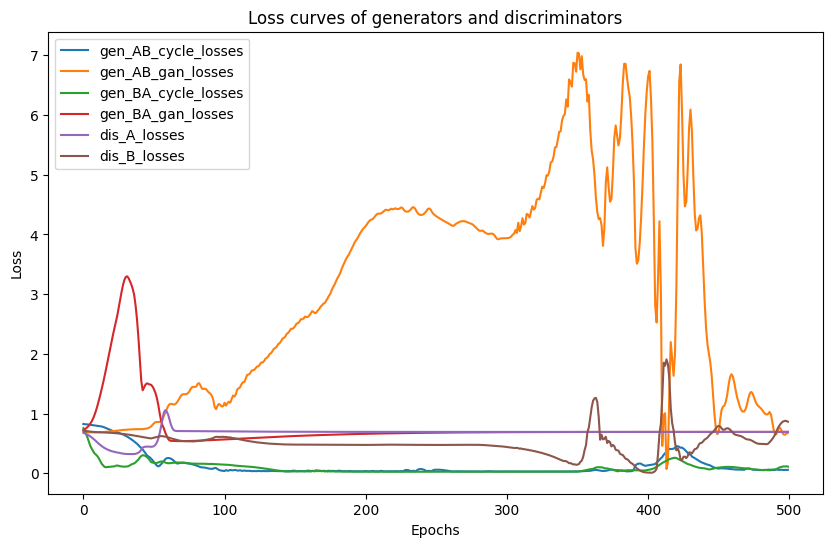

In [ ]:
fig = plt.figure(figsize=(10, 6))
for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)
plt.legend()
plt.title("Loss curves of generators and discriminators")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Q. Looking at the loss curves above, can you identify a limitation of CycleGAN?**

A. 

In [ ]:
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.generator(real_B)
fake_B = gan_AB.generator(real_A)

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from trained generators")
fig.show()

**Now, visualize how the generators transforms samples across distributions.**

Explanation of the graphs:

The function `visualize_point_correspondence` visualizes the correspondence across two sets of points by giving points that correspond to each other the same color. The left subplot corresponds to the points passed in as the first argument, while the right subplot corresponds to the second argument. For example, if you call `visualize_point_correspondence(real_A, fake_B)`, where `fake_B` is transformed from `real_A` by the generator, then an orange point in the left subplot is transformed by the generator to the corresponding orange point in the right subplot.

In [ ]:
visualize_point_correspondence(real_A, fake_B)

In [ ]:
visualize_point_correspondence(real_B, fake_A)

## Part (D): Visualize sample correspondence

In [ ]:
visualize_point_correspondence(real_A, fake_A)

In [ ]:
visualize_point_correspondence(real_B, fake_B)

**Why does it seem that the clusters of ”real A samples” and the clusters of ”fake A samples” are switched, despite a low cycle loss observed at the end of training?**

Answer the question in written portion.

In [ ]:
# TODO: the remaining cells in this question are SOLUTION ONLY. Remove them in the homework.
recon_A = gan_BA.generator(gan_AB.generator(real_A))
recon_B = gan_AB.generator(gan_BA.generator(real_B))

In [ ]:
visualize_point_correspondence(real_A, recon_A)

In [ ]:
visualize_point_correspondence(real_B, recon_B)

In [ ]:
visualize_point_correspondence(real_A, real_B)

## Part E: Pretraining with GAN loss only

### Pretrain with $\lambda = 0$

In [ ]:
# Reinitialize
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [ ]:
# Pretrain
lambda_pretrain = 0 # TODO: Enter lambda for pretraining
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=1000, cycle_loss_weight=lambda_pretrain)

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7239; Generator AB Cycle loss:  0.8255; Generator BA Cycle loss:  0.7572; Discriminator A loss:  0.6781; Discriminator B loss:  0.7197: : 1it [00:01,  1.69s/it]
Epoch 1; Generator AB GAN loss:  0.6922; Generator BA GAN loss:  0.7237; Generator AB Cycle loss:  0.8235; Generator BA Cycle loss:  0.7947; Discriminator A loss:  0.6768; Discriminator B loss:  0.7120: : 1it [00:00,  4.64it/s]
Epoch 2; Generator AB GAN loss:  0.6895; Generator BA GAN loss:  0.7218; Generator AB Cycle loss:  0.8221; Generator BA Cycle loss:  0.8270; Discriminator A loss:  0.6757; Discriminator B loss:  0.7078: : 1it [00:00,  4.48it/s]
Epoch 3; Generator AB GAN loss:  0.6881; Generator BA GAN loss:  0.7195; Generator AB Cycle loss:  0.8247; Generator BA Cycle loss:  0.8538; Discriminator A loss:  0.6748; Discriminator B loss:  0.7039: : 1it [00:00,  4.11it/s]
Epoch 4; Generator AB GAN loss:  0.6868; Generator BA GAN loss:  0.7165; Generator AB Cy

In [ ]:
# Obtain generators and samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

# Visualize samples
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from pretrained generators")
fig.show()

### Now, train with both GAN loss and cycle loss.

In [ ]:
# Fine tuning
lambda_train = 5 # TODO: Enter lambda value for fine tuning
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_train)

Epoch 0; Generator AB GAN loss:  0.7859; Generator BA GAN loss:  1.1588; Generator AB Cycle loss:  1.1177; Generator BA Cycle loss:  0.2567; Discriminator A loss:  0.4738; Discriminator B loss:  0.6847: : 1it [00:00,  1.01it/s]
Epoch 1; Generator AB GAN loss:  0.7811; Generator BA GAN loss:  1.1659; Generator AB Cycle loss:  1.1127; Generator BA Cycle loss:  0.2529; Discriminator A loss:  0.4691; Discriminator B loss:  0.6825: : 1it [00:00,  2.85it/s]
Epoch 2; Generator AB GAN loss:  0.7788; Generator BA GAN loss:  1.1914; Generator AB Cycle loss:  1.1077; Generator BA Cycle loss:  0.2513; Discriminator A loss:  0.4647; Discriminator B loss:  0.6793: : 1it [00:00,  4.59it/s]
Epoch 3; Generator AB GAN loss:  0.7790; Generator BA GAN loss:  1.1949; Generator AB Cycle loss:  1.1027; Generator BA Cycle loss:  0.2510; Discriminator A loss:  0.4604; Discriminator B loss:  0.6755: : 1it [00:00,  4.36it/s]
Epoch 4; Generator AB GAN loss:  0.7807; Generator BA GAN loss:  1.1870; Generator AB Cy

In [ ]:
# Obtain generators and samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

# Visualize samples
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from the trained generators")
fig.show()

**Q. How does pretraining without cycle loss affect subsequent training where cycle loss is present? Can you give a possible explanation?**

Write your answers in the written portion.

## Part F: Pretraining with GAN loss and cycle loss

In [ ]:
# Reinitialize
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

### Pretrain with $\lambda = 5$

In [ ]:
# Pretrain
lambda_pretrain = 5 # TODO: Enter lambda for pretraining
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=1000, cycle_loss_weight=lambda_pretrain)

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7239; Generator AB Cycle loss:  0.8255; Generator BA Cycle loss:  0.7572; Discriminator A loss:  0.6781; Discriminator B loss:  0.7197: : 1it [00:01,  1.73s/it]
Epoch 1; Generator AB GAN loss:  0.6938; Generator BA GAN loss:  0.7383; Generator AB Cycle loss:  0.8226; Generator BA Cycle loss:  0.7075; Discriminator A loss:  0.6693; Discriminator B loss:  0.7117: : 1it [00:00,  4.33it/s]
Epoch 2; Generator AB GAN loss:  0.6899; Generator BA GAN loss:  0.7550; Generator AB Cycle loss:  0.8195; Generator BA Cycle loss:  0.6524; Discriminator A loss:  0.6586; Discriminator B loss:  0.7079: : 1it [00:00,  4.57it/s]
Epoch 3; Generator AB GAN loss:  0.6879; Generator BA GAN loss:  0.7762; Generator AB Cycle loss:  0.8189; Generator BA Cycle loss:  0.5913; Discriminator A loss:  0.6465; Discriminator B loss:  0.7041: : 1it [00:00,  4.65it/s]
Epoch 4; Generator AB GAN loss:  0.6867; Generator BA GAN loss:  0.8022; Generator AB Cy

In [ ]:
# Obtain generators and samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

# Visualize samples
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from pretrained generators")
fig.show()

### Now, train with GAN loss ONLY.

In [ ]:
# Fine tuning
lambda_train = 0 # TODO: Enter lambda value for fine tuning
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_train)

Epoch 0; Generator AB GAN loss:  0.6662; Generator BA GAN loss:  0.6931; Generator AB Cycle loss:  0.0547; Generator BA Cycle loss:  0.1140; Discriminator A loss:  0.6932; Discriminator B loss:  0.8380: : 1it [00:00,  1.05it/s]
Epoch 1; Generator AB GAN loss:  0.6913; Generator BA GAN loss:  0.6956; Generator AB Cycle loss:  0.0950; Generator BA Cycle loss:  0.1256; Discriminator A loss:  0.6931; Discriminator B loss:  0.8923: : 1it [00:00,  4.60it/s]
Epoch 2; Generator AB GAN loss:  0.7631; Generator BA GAN loss:  0.6938; Generator AB Cycle loss:  0.1423; Generator BA Cycle loss:  0.1376; Discriminator A loss:  0.6931; Discriminator B loss:  0.9227: : 1it [00:00,  4.53it/s]
Epoch 3; Generator AB GAN loss:  0.4807; Generator BA GAN loss:  0.6920; Generator AB Cycle loss:  0.1899; Generator BA Cycle loss:  0.1497; Discriminator A loss:  0.6931; Discriminator B loss:  0.9510: : 1it [00:00,  4.86it/s]
Epoch 4; Generator AB GAN loss:  0.5378; Generator BA GAN loss:  0.6913; Generator AB Cy

In [ ]:
# Obtain generators and samples
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

# Visualize samples
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])
fig.add_trace(go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'), row=1, col=1)
fig.add_trace(go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'), row=1, col=2)
fig.add_trace(go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'), row=1, col=1)
fig.add_trace(go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False), row=1, col=2)
fig.update_layout(title_text="Real samples and fake samples from the trained generators")
fig.show()

**Q. How does pretraining with cycle loss affect subsequent training where cycle loss is absent? Can you give a possible explanation?**

Write your answers in the written portion.